In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import scipy as sp
import pandas as pd
import functools as fts
import multiprocessing as mp
from tqdm.notebook import tqdm
from tqdm.contrib import tzip, tenumerate, tmap

from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.storagelevel import StorageLevel
from pyspark.sql.functions import col
import pyspark.sql.types as pstype
import pyspark.sql.functions as F
import pyspark as ps

import matplotlib as mlt
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
import japanize_matplotlib

from time_series_model import *
from create_time_series import *

%matplotlib inline
%matplotlib ipympl

In [2]:
np.set_printoptions(threshold=100, precision=6, linewidth=10000)

In [3]:
SPECIFIED_PATH = "csv_data/"
SPECIFIED_DATE = "20240918"
SPECIFIED_CSV  = SPECIFIED_PATH + SPECIFIED_DATE

In [4]:
pd_data = pd.read_csv(SPECIFIED_CSV + "_urp_data.csv")
pd_data

,x_data
0,-1.720762e+04
1,-2.197576e+04
2,-3.540246e+04
3,-3.127725e+04
4,-3.265458e+04
...,...
4995,1.245592e+07
4996,1.247518e+07
4997,1.249003e+07
4998,1.249184e+07


各時系列軸の係数： [[0.998739]]
切片の係数： [[169.841043]]
1次トレンドの係数： [[0.669804]]
2次トレンドの係数： [[0.000691]]


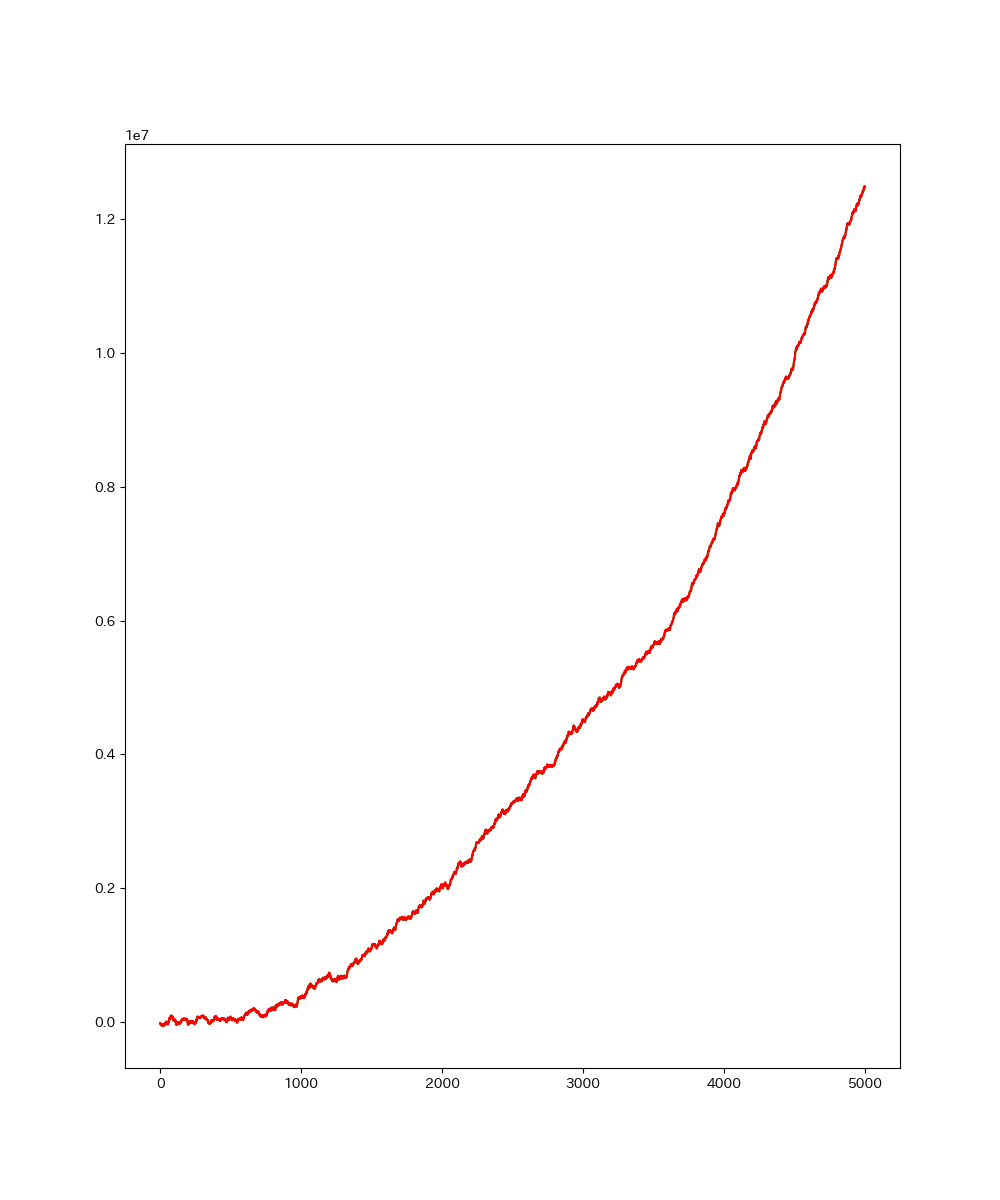

In [5]:
# regression：データ構造により以下から指定
# n  ・・・定数項なし&トレンドなし
# c  ・・・定数項あり&トレンドなし
# ct ・・・定数項あり&1次のトレンドあり
# ctt・・・定数項あり&1次のトレンドあり&2次のトレンドあり
dfruler = Dickey_Fuller_Test(pd_data, regression="ctt")
dfruler.fit()
y_pred = dfruler.predict(pd_data, np.arange(1, len(pd_data)+1).reshape([len(pd_data), 1]))

plt.figure(figsize=(10, 12))
plt.plot(pd_data[-len(y_pred):], "-", color="green")
plt.plot(y_pred,                 "-", color="red")

print("各時系列軸の係数：", dfruler.alpha)
print("切片の係数：", dfruler.alpha0)
print("1次トレンドの係数：", dfruler.trend_1st)
print("2次トレンドの係数：", dfruler.trend_2nd)

AR model | aic
AR(1) | 18.419155265683177
AR(2) | 18.419411908688605
AR(3) | 18.419813490542584
AR(4) | 18.420203325472002
AR(5) | 18.420442871863656
AR(6) | 18.420655853280003
AR(7) | 18.42055650891355
AR(8) | 18.420935232621726
AR(9) | 18.421329869595784
AR(10) | 18.42158354566849
AR(11) | 18.42197597209056
AR(12) | 18.422289015620226
AR(13) | 18.42250671487823
AR(14) | 18.422798228426025
AR(15) | 18.423101351594838
AR(16) | 18.42343202678768
AR(17) | 18.423833638771377
AR(18) | 18.424195722714675
AR(19) | 18.42458582245125
AR(20) | 18.424559316553925
selected orders | 1
各時系列軸の係数： [[ 1.000105 -0.01197 ]]
切片の係数： [[93.64532]]
1次トレンドの係数： [[0.805572]]
2次トレンドの係数： [[0.]]


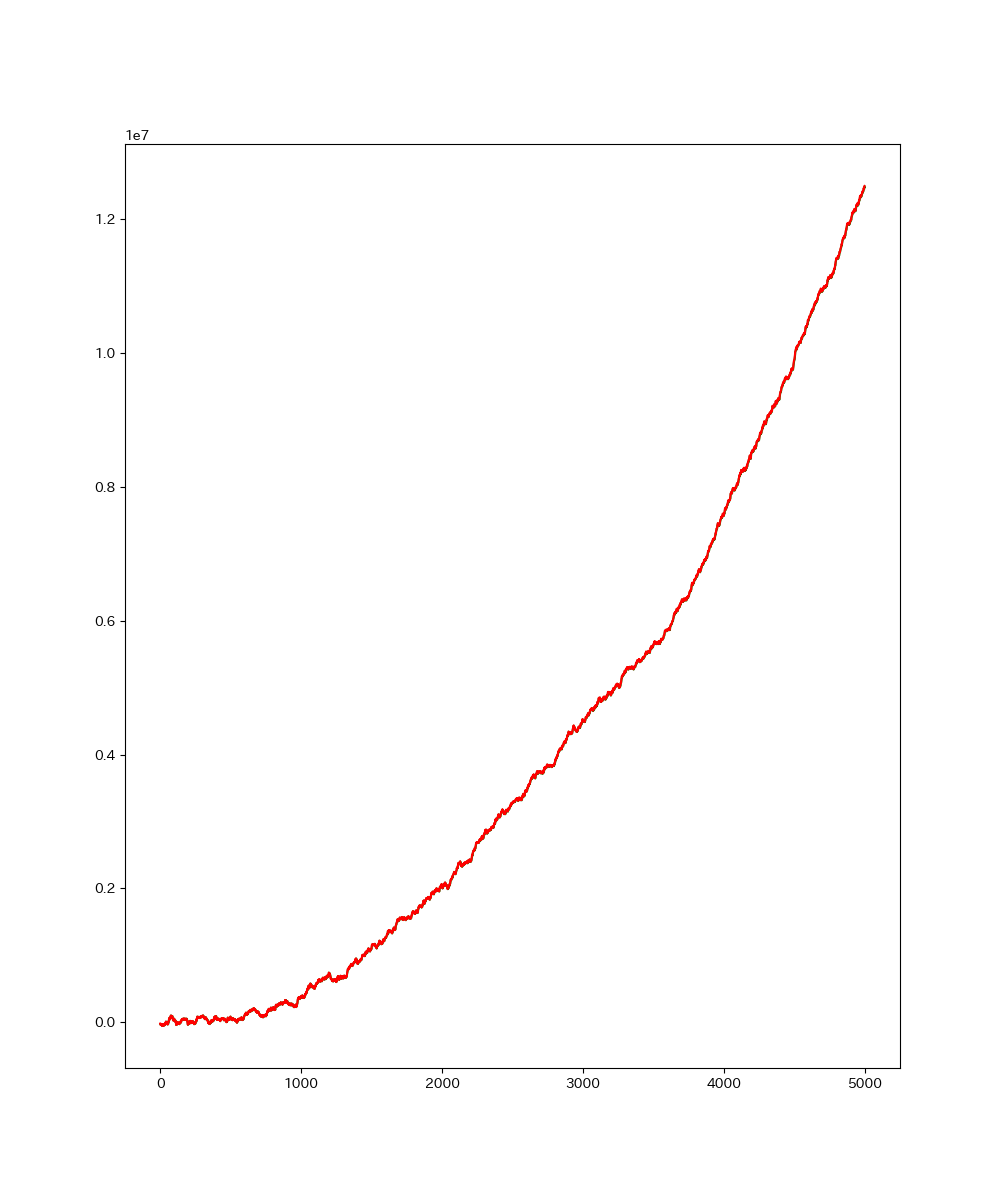

In [6]:
# regression：データ構造により以下から指定
# n  ・・・定数項なし&トレンドなし
# c  ・・・定数項あり&トレンドなし
# ct ・・・定数項あり&1次のトレンドあり
# ctt・・・定数項あり&1次のトレンドあり&2次のトレンドあり
adfruler = Augmented_Dickey_Fuller_Test(pd_data, regression="ct")
adfruler.select_order(maxlag=20, ic="aic", isVisible=True)
y_pred = adfruler.predict(pd_data, np.arange(1, len(pd_data)+1).reshape([len(pd_data), 1]))

plt.figure(figsize=(10, 12))
plt.plot(pd_data[-len(y_pred):], "-", color="green")
plt.plot(y_pred,                 "-", color="red")

print("各時系列軸の係数：", adfruler.alpha.T)
print("切片の係数：", adfruler.alpha0)
print("1次トレンドの係数：", adfruler.trend_1st)
print("2次トレンドの係数：", adfruler.trend_2nd)

  0%|          | 0/100000 [00:00<?, ?it/s]

(array([3.681087e-02, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 3.681087e-02, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 7.362174e-02, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 3.681087e-02, 1.472435e-01, 3.681087e-02, 1.472435e-01, 7.362174e-02, 7.362174e-02, 0.000000e+00, 0.000000e+00, 2.944869e-01, 1.472435e-01, 2.208652e-01, 1.104326e-01, 3.312978e-01, 4.049196e-01, 5.153522e-01, 5.153522e-01, 4.785413e-01, 5.889739e-01, 7.730282e-01, 1.141137e+00, 8.466500e-01, 1.141137e+00, 1.214759e+00, 1.840543e+00, 2.171841e+00, 2.024598e+00, 2.908059e+00, 3.276167e+00, 3.791519e+00, 4.748602e+00, 4.785413e+00, 6.478713e+00, 7.178119e+00, 8.981852e+00, 1.023342e+01, 1.174267e+01, 1.328872e+01, 1.446667e+01, 1.674895e+01, 1.965700e+01, 2.539950e+01, 2.646701e+01, 3.117881e+01, 3.408686e+01, 4.207482e+01, 4.789094e+01, 5.554760e+01, 5.904463e+01, 6.633319e+01, 7.524142e+01

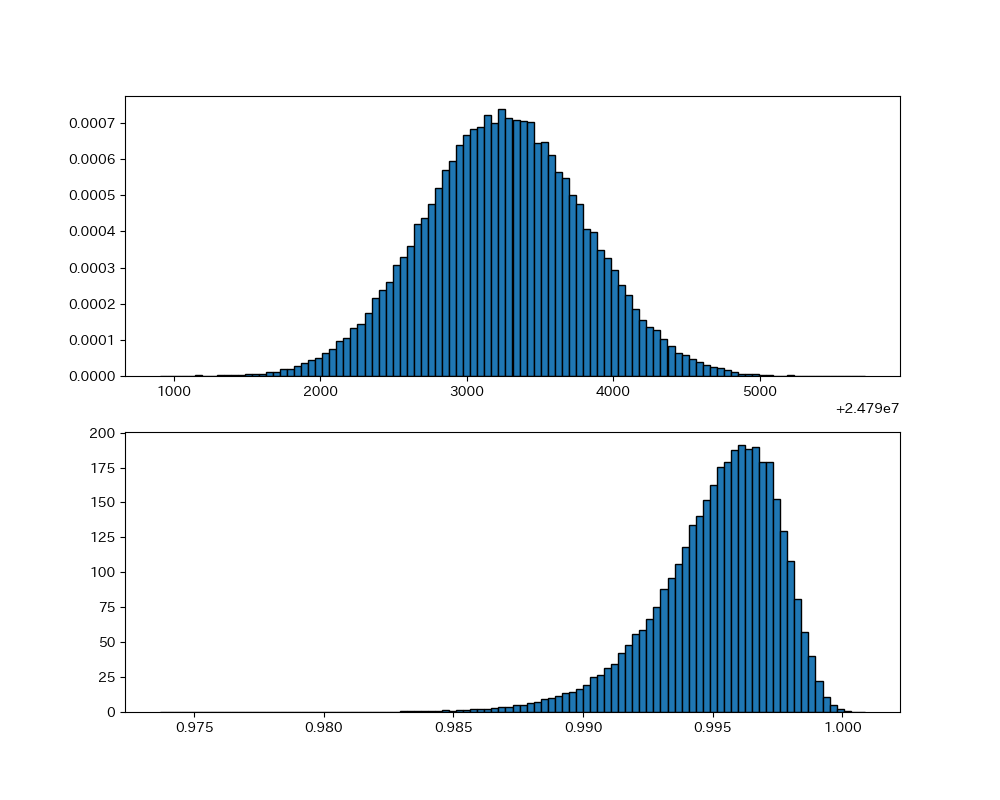

In [7]:
# regression：データ構造により以下から指定
# n  ・・・定数項なし&トレンドなし
# c  ・・・定数項あり&トレンドなし
# ct ・・・定数項あり&1次のトレンドあり
# ctt・・・定数項あり&1次のトレンドあり&2次のトレンドあり

T = 3000
N = 10**5
sigma = 10
const = 5000
δ1    = 10
δ2    = 5.5
regression = "ctt"

save_x  = [] #1次元から配列生成:保存用
save_ρ  = [] #1次元から配列生成:保存用

if __name__ == "__main__":
    with mp.Pool(processes=mp.cpu_count()-1) as p:
        input_list = [[regression, T, sigma, const, δ1, δ2] for _ in range(0, N)]
        for res in tqdm(p.imap_unordered(create_time_data, input_list), total=N, leave=False):
            x, alpha = res
            
            save_x.append(x)
            save_ρ.append(alpha)
    

# ヒストグラム
fig = plt.figure(figsize = (10,8))

ax = fig.add_subplot(2, 1, 1)
ax.hist(save_x,  bins=100, histtype='barstacked', ec='black',density=True)

ax = fig.add_subplot(2, 1, 2)
ax.hist(save_ρ,  bins=100, histtype='barstacked', ec='black',density=True)


In [ ]:
return False
# regression：データ構造により以下から指定
# n  ・・・定数項なし&トレンドなし
# c  ・・・定数項あり&トレンドなし
# ct ・・・定数項あり&1次のトレンドあり
# ctt・・・定数項あり&1次のトレンドあり&2次のトレンドあり


save_ρ  = {
    "n"   : [],
    "c"   : [],
    "ct"  : [],
    "ctt" : [],
}
if __name__ == "__main__":
    with mp.Pool(processes=mp.cpu_count()-1) as p:
        for regression in tqdm(["n", "c", "ct", "ctt"]):
            T = 5000
            N = 10**7
            sigma = 20
            const = 5000
            δ1    = 20
            δ2    = 10
            
            input_list = [[regression, T, sigma, const, δ1, δ2] for _ in range(0, N)]
            for res in tqdm(p.imap_unordered(create_time_data, input_list), total=N, leave=False):
                _, alpha = res
            
                save_ρ[regression].append(alpha)

reg_n   = np.percentile(save_ρ["n"],   q=[0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5, 2, 98, 98.5, 98.8, 99, 99.2, 99.5, 99.8, 99.9])
reg_c   = np.percentile(save_ρ["c"],   q=[0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5, 2, 98, 98.5, 98.8, 99, 99.2, 99.5, 99.8, 99.9])
reg_ct  = np.percentile(save_ρ["ct"],  q=[0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5, 2, 98, 98.5, 98.8, 99, 99.2, 99.5, 99.8, 99.9])
reg_ctt = np.percentile(save_ρ["ctt"], q=[0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5, 2, 98, 98.5, 98.8, 99, 99.2, 99.5, 99.8, 99.9])

print("q(%)::  [0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5, 2, 98, 98.5, 98.8, 99, 99.2, 99.5, 99.8, 99.9]")
print("n   :: ", reg_n)
print("c   :: ", reg_c)
print("ct  :: ", reg_ct)
print("ctt :: ", reg_ctt)

pd_ρ_data = pd.DataFrame(save_ρ)
pd_ρ_data.to_csv("./csv_data/DF_distribution_tmp.csv.zst", header=True, index=False, compression="zstd")

In [8]:
#return False
save_ρ  = pd.read_csv("./csv_data/DF_distribution.csv.zst",     header=0, compression="zstd").to_dict(orient="list")
save_ρ2 = pd.read_csv("./csv_data/DF_distribution_ctt.csv.zst", header=0, compression="zstd").to_dict(orient="list")

Text(0.5, 1.0, 'Dickey Fuller分布  定数項あり&1次のトレンドあり&2次のトレンドあり')

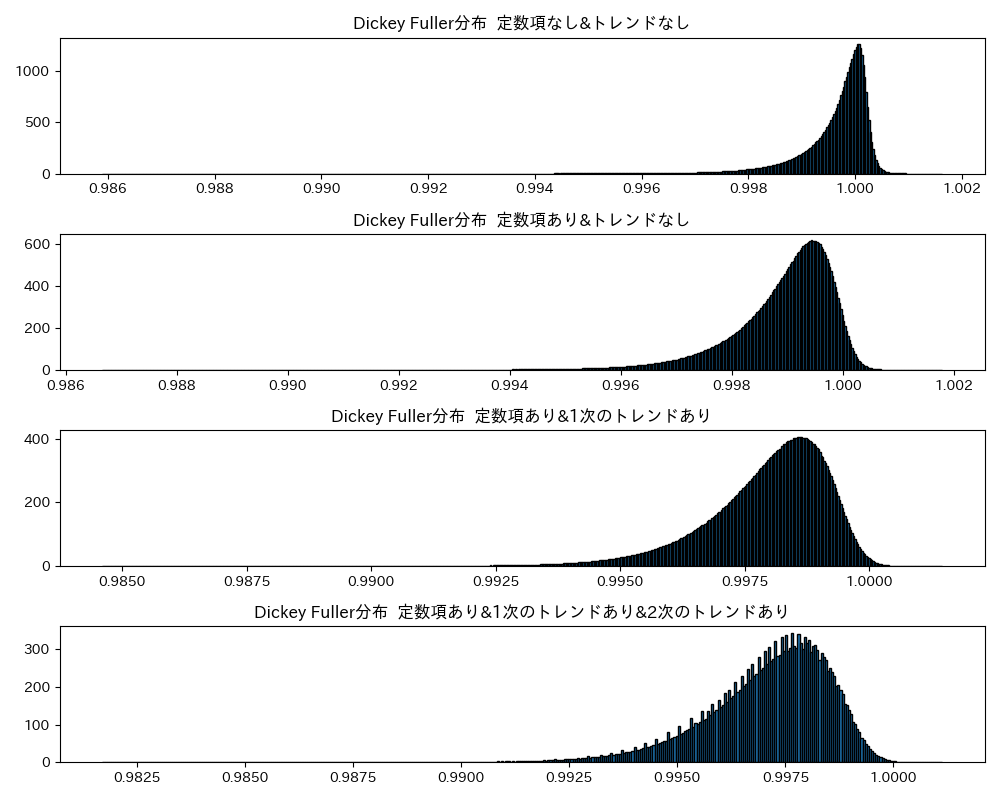

In [9]:
#return False
# ヒストグラム
fig = plt.figure(figsize = (10,8), tight_layout=True)

ax = fig.add_subplot(4, 1, 1)
ax.hist(save_ρ["n"],    bins=600, histtype='barstacked', ec='black', density=True)
ax.set_title("Dickey Fuller分布  定数項なし&トレンドなし")

ax = fig.add_subplot(4, 1, 2)
ax.hist(save_ρ["c"],    bins=600, histtype='barstacked', ec='black', density=True)
ax.set_title("Dickey Fuller分布  定数項あり&トレンドなし")

ax = fig.add_subplot(4, 1, 3)
ax.hist(save_ρ["ct"],   bins=600, histtype='barstacked', ec='black', density=True)
ax.set_title("Dickey Fuller分布  定数項あり&1次のトレンドあり")

ax = fig.add_subplot(4, 1, 4)
ax.hist(save_ρ["ctt"] + save_ρ2["ctt"],  bins=400, histtype='barstacked', ec='black', density=True)
ax.set_title("Dickey Fuller分布  定数項あり&1次のトレンドあり&2次のトレンドあり")

In [10]:
# regression：データ構造により以下から指定
# n  ・・・定数項なし&トレンドなし
# c  ・・・定数項あり&トレンドなし
# ct ・・・定数項あり&1次のトレンドあり
# ctt・・・定数項あり&1次のトレンドあり&2次のトレンドあり
dfruler = Dickey_Fuller_Test(pd_data, regression="ct")
dfruler.fit()
result = dfruler.dfRuller(qlist=[1, 5, 10])

print("DF Statistic: ", result[0])
print("p-value: ", result[1])
print("used lag: ", result[2])
print("data num: ", result[3])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
print("DF検定(有意水準5%)：", True if dfruler.pvalue < 0.05 else False)

DF Statistic:  1.0000999434418887
p-value:  0.9980739090909091
used lag:  1
data num:  4999
	1%: 0.994
	5%: 0.996
	10%: 0.996
DF検定(有意水準5%)： False


In [17]:
pd_data = pd.read_csv(SPECIFIED_CSV + "_urp_data_lags.csv")
pd_data

,x_data
0,5.000000e+02
1,1.436774e+06
2,1.408681e+06
3,1.109761e+06
4,4.067118e+05
...,...
4995,7.013399e+06
4996,5.547354e+06
4997,7.591711e+06
4998,6.852316e+06


In [18]:
# regression：データ構造により以下から指定
# n  ・・・定数項なし&トレンドなし
# c  ・・・定数項あり&トレンドなし
# ct ・・・定数項あり&1次のトレンドあり
# ctt・・・定数項あり&1次のトレンドあり&2次のトレンドあり
adfruler = Augmented_Dickey_Fuller_Test(pd_data, regression="ctt")
adfruler.select_order(maxlag=20, ic="aic", isVisible=False)
result = adfruler.adfRuller(qlist=[1, 5, 10])

print("ADF Statistic: ", result[0])
print("p-value: ", result[1])
print("used lag: ", result[2])
print("data num: ", result[3])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
print("ADF検定(有意水準5%)：", True if adfruler.pvalue < 0.05 else False)

ADF Statistic:  0.9805898650832265
p-value:  0.0105805
used lag:  4
data num:  4995
	1%: 0.980
	5%: 0.985
	10%: 0.987
ADF検定(有意水準5%)： True


In [ ]:
return False
# regression：データ構造により以下から指定
# n  ・・・定数項なし&トレンドなし
# c  ・・・定数項あり&トレンドなし
# ct ・・・定数項あり&1次のトレンドあり
# ctt・・・定数項あり&1次のトレンドあり&2次のトレンドあり
save_ρ  = {
    "n"   : [],
    "c"   : [],
    "ct"  : [],
    "ctt" : [],
}
if __name__ == "__main__":
    with mp.Pool(processes=mp.cpu_count()-1) as p:
        for regression in tqdm(["n", "c", "ct", "ctt"]):
            T = 5000
            N = 10**7
            lags       = 5
            data_num   = 5000
            const      = 500
            δ1         = 1
            δ2         = 1
            Σ          = 20
            coef       = np.random.rand(lags)
            coef       = coef / coef.sum()
            
            input_list = [[regression, lags, T, coef, Σ, const, δ1, δ2] for _ in range(0, N)]
            for res in tqdm(p.imap_unordered(create_time_data_lag, input_list), total=N, leave=False):
                _, alpha = res
            
                save_ρ[regression].append(alpha)

reg_n   = np.percentile(save_ρ["n"],   q=[0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5, 2, 98, 98.5, 98.8, 99, 99.2, 99.5, 99.8, 99.9])
reg_c   = np.percentile(save_ρ["c"],   q=[0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5, 2, 98, 98.5, 98.8, 99, 99.2, 99.5, 99.8, 99.9])
reg_ct  = np.percentile(save_ρ["ct"],  q=[0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5, 2, 98, 98.5, 98.8, 99, 99.2, 99.5, 99.8, 99.9])
reg_ctt = np.percentile(save_ρ["ctt"], q=[0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5, 2, 98, 98.5, 98.8, 99, 99.2, 99.5, 99.8, 99.9])

print("q(%)::  [0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5, 2, 98, 98.5, 98.8, 99, 99.2, 99.5, 99.8, 99.9]")
print("n   :: ", reg_n)
print("c   :: ", reg_c)
print("ct  :: ", reg_ct)
print("ctt :: ", reg_ctt)

pd_ρ_data = pd.DataFrame(save_ρ)
pd_ρ_data.to_csv("./csv_data/ADF_distribution_tmp.csv.zst", header=True, index=False, compression="zstd")

In [13]:
#return False
save_ρ  = pd.read_csv("./csv_data/ADF_distribution.csv.zst",     header=0, compression="zstd").to_dict(orient="list")

Text(0.5, 1.0, 'Dickey Fuller分布  定数項あり&1次のトレンドあり&2次のトレンドあり')

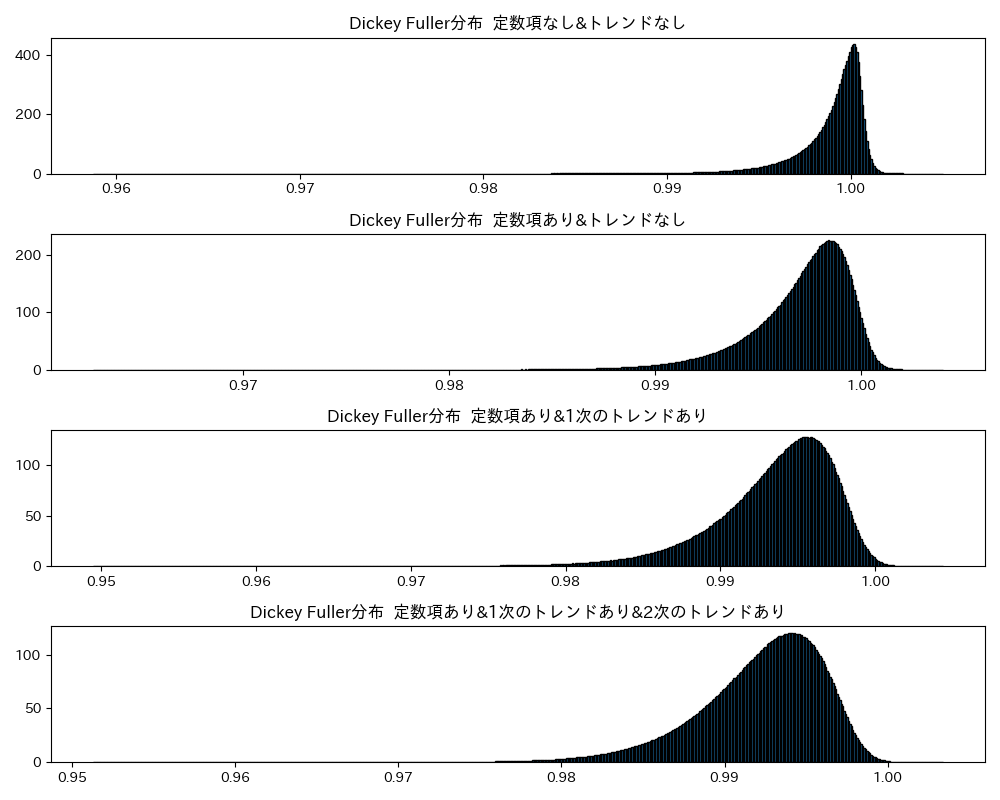

In [14]:
#return False
# ヒストグラム
fig = plt.figure(figsize = (10,8), tight_layout=True)

ax = fig.add_subplot(4, 1, 1)
ax.hist(save_ρ["n"],    bins=600, histtype='barstacked', ec='black', density=True)
ax.set_title("Dickey Fuller分布  定数項なし&トレンドなし")

ax = fig.add_subplot(4, 1, 2)
ax.hist(save_ρ["c"],    bins=600, histtype='barstacked', ec='black', density=True)
ax.set_title("Dickey Fuller分布  定数項あり&トレンドなし")

ax = fig.add_subplot(4, 1, 3)
ax.hist(save_ρ["ct"],   bins=600, histtype='barstacked', ec='black', density=True)
ax.set_title("Dickey Fuller分布  定数項あり&1次のトレンドあり")

ax = fig.add_subplot(4, 1, 4)
ax.hist(save_ρ["ctt"],  bins=600, histtype='barstacked', ec='black', density=True)
ax.set_title("Dickey Fuller分布  定数項あり&1次のトレンドあり&2次のトレンドあり")